In [1]:
import sys
sys.path.append('../')

In [2]:
import import_ipynb

In [3]:
from models.model_resnet18_FC             import Yolov1 as Yolo_resnet18
from models.model_resnet18_CNN_BLOCK_8_FC import Yolov1 as Yolo_resnet18_ft

from models.model_resnet50_FC             import Yolov1 as Yolo_resnet50
from models.model_resnet50_CNN_BLOCK_8_FC import Yolov1 as Yolo_resnet50_ft

from models.model_vgg19_FC                import Yolov1 as Yolo_VGG19
from models.model_vgg19_unfrozenCNN_FC    import Yolov1 as Yolo_VGG19_ft

importing Jupyter notebook from C:\Users\andri\Documents\Everything\YOLO-object-detection\train\..\models\model_resnet18_FC.ipynb
importing Jupyter notebook from C:\Users\andri\Documents\Everything\YOLO-object-detection\train\..\models\model_resnet18_CNN_BLOCK_8_FC.ipynb
importing Jupyter notebook from C:\Users\andri\Documents\Everything\YOLO-object-detection\train\..\models\model_resnet50_FC.ipynb
importing Jupyter notebook from C:\Users\andri\Documents\Everything\YOLO-object-detection\train\..\models\model_resnet50_CNN_BLOCK_8_FC.ipynb
importing Jupyter notebook from C:\Users\andri\Documents\Everything\YOLO-object-detection\train\..\models\model_vgg19_FC.ipynb
importing Jupyter notebook from C:\Users\andri\Documents\Everything\YOLO-object-detection\train\..\models\model_vgg19_unfrozenCNN_FC.ipynb


In [4]:
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
from dataset.dataset import VOCDataset
from train.utils import (
    non_max_suppression,
    mean_average_precision,
    intersection_over_union,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
)
from loss.loss import YoloLoss
from matplotlib import pyplot as plt

importing Jupyter notebook from C:\Users\andri\Documents\Everything\YOLO-object-detection\train\..\dataset\dataset.ipynb
importing Jupyter notebook from C:\Users\andri\Documents\Everything\YOLO-object-detection\train\..\train\utils.ipynb
importing Jupyter notebook from C:\Users\andri\Documents\Everything\YOLO-object-detection\train\..\loss\loss.ipynb


In [5]:
seed = 123
torch.manual_seed(seed)

DEVICE = "cuda" if torch.cuda.is_available else "cpu"

LEARNING_RATE = 2e-5                      # try different learning rates
# WEIGHT_DECAY = 0                        # try something here, why 0??
BATCH_SIZE = 64
EPOCHS = 10
PIN_MEMORY = True
SAVE_MODEL_PATH = "../output/models/best_model.pth"
IMG_DIR = "../dataset/VOC_dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages/"
LABEL_TRAIN_DIR = "../dataset/labels/train/"
LABEL_VAL_DIR = "../dataset/labels/val/"

In [6]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

In [7]:
transform = Compose([transforms.Resize((224, 224)), transforms.ToTensor(),])

In [8]:
def train_fn(train_loader, model, optimizer, loss_fn):
    mean_loss = []

    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mean_loss = sum(mean_loss)/len(mean_loss)
    return mean_loss

In [9]:
def val_fn(val_loader, model, optimizer, loss_fn):
    model.eval()
    mean_loss = []
    
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(val_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = loss_fn(out, y)
            mean_loss.append(loss.item())

        mean_loss = sum(mean_loss)/len(mean_loss)
        
    model.train()
    return 0, mean_loss

In [10]:
# Yolo parameters
split_size = 7 # split size
box_count = 2 # bounding boxes per split
class_count = 20 # number of classes

In [11]:
model = Yolo_resnet50(S=split_size, B=box_count, C=class_count).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = YoloLoss(S=split_size, B=box_count, C=class_count)

In [12]:
train_dataset = VOCDataset(
    transform=transform,
    img_dir=IMG_DIR,
    label_dir=LABEL_TRAIN_DIR,
    S=split_size, 
    B=box_count, 
    C=class_count
)

val_dataset = VOCDataset(
    transform=transform, 
    img_dir=IMG_DIR, 
    label_dir=LABEL_VAL_DIR,
    S=split_size, 
    B=box_count, 
    C=class_count
)

In [13]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

In [14]:
# early stopping variables
EARLY_STOPPING_LIMIT = 100
epochs_since_last_improvement = 0
best_loss = float('inf')
best_model = model.state_dict()

In [15]:
mean_loss_history_train = []
mean_avg_prec_history_train = []
mean_loss_history_val = []
mean_avg_prec_history_val = []
for epoch in tqdm(range(EPOCHS)):
    pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold=0.5, threshold=0.4)
    
    mean_avg_prec_train = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
    # print(f"Train mAP: {mean_avg_prec}")
    mean_loss_train = train_fn(train_loader, model, optimizer, loss_fn)
    #print(f"Mean loss was {mean_loss}")
    
    # if EPOCHS % 10:
    # validation
    mean_avg_prec_val, mean_loss_val = val_fn(val_loader, model, optimizer, loss_fn)

    # append metrics
    mean_avg_prec_history_train.append(mean_avg_prec_train)
    mean_loss_history_train.append(mean_loss_train)
    mean_avg_prec_history_val.append(mean_avg_prec_val)
    mean_loss_history_val.append(mean_loss_val)

    # early stopping
    if mean_loss_val < best_loss:
        epochs_since_last_improvement = 0
        best_loss = mean_loss_val
        best_model = model.state_dict() 
    else:
        epochs_since_last_improvement += 1
        if epochs_since_last_improvement >= EARLY_STOPPING_LIMIT:
            print(f"Early stopped at epoch {epoch}!")
            print(f"Best model at epoch {epoch-epochs_since_last_improvement}!")
            model.load_state_dict(best_model)
            break

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [51:28<00:00, 308.81s/it]


In [16]:
model.eval()

Yolov1(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

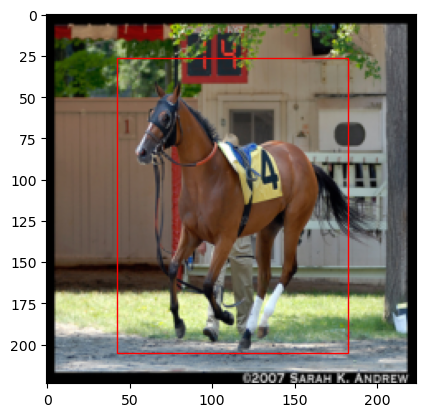

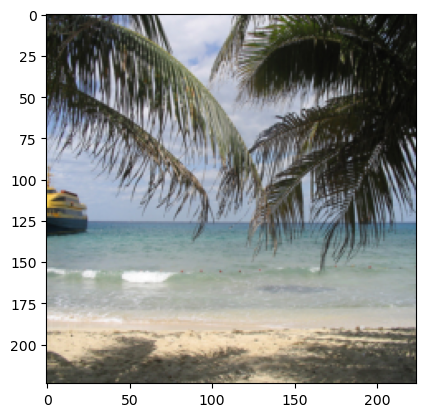

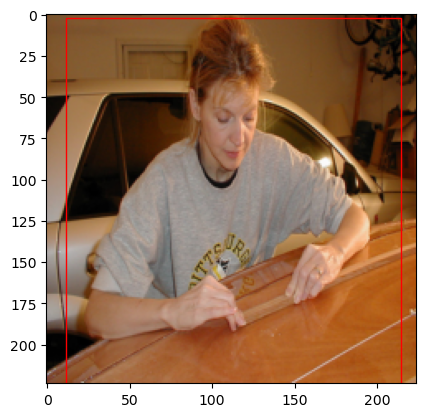

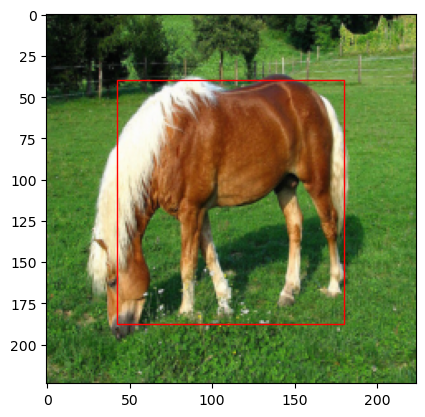

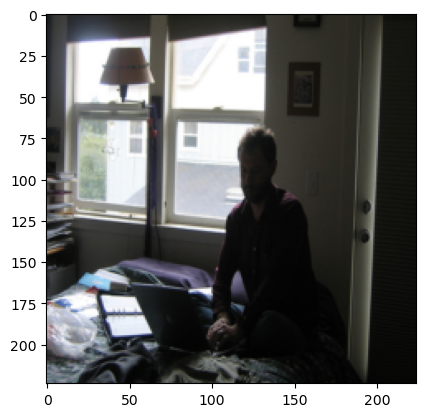

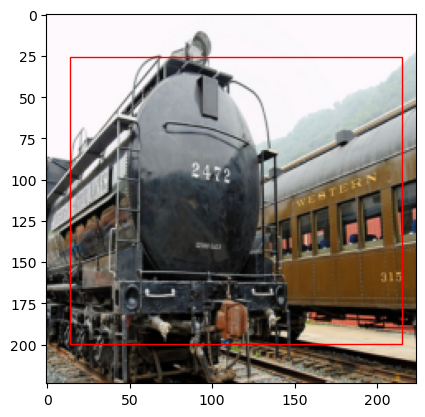

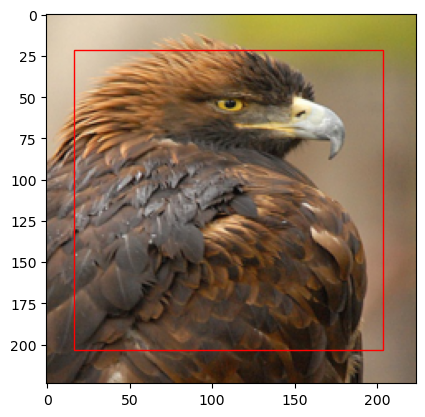

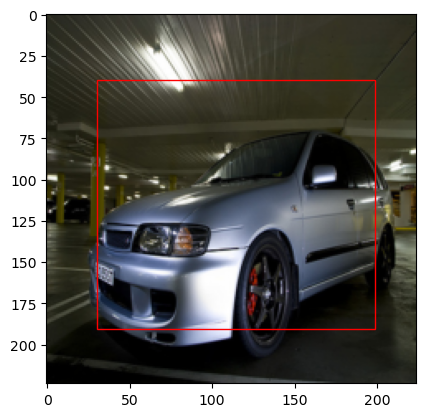

In [17]:
# Plot predictions on train data
with torch.no_grad():
    for x, y in train_loader:
        x = x.to(DEVICE)
        for idx in range(8):
            out = model(x)
            bboxes = cellboxes_to_boxes(out)
            bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
            plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)
        break

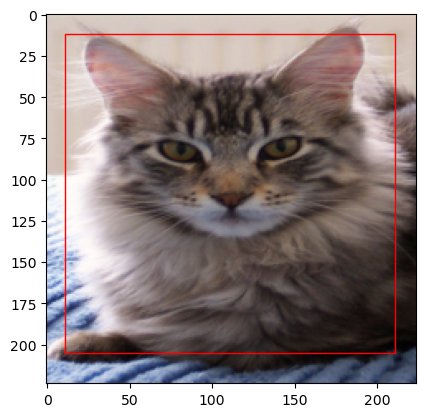

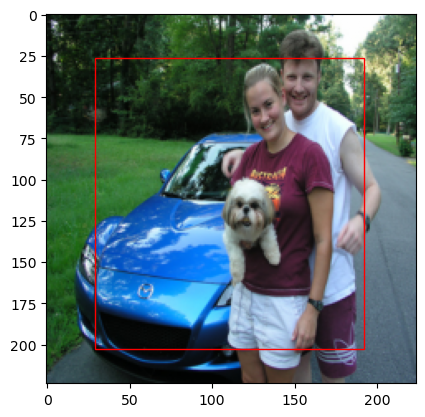

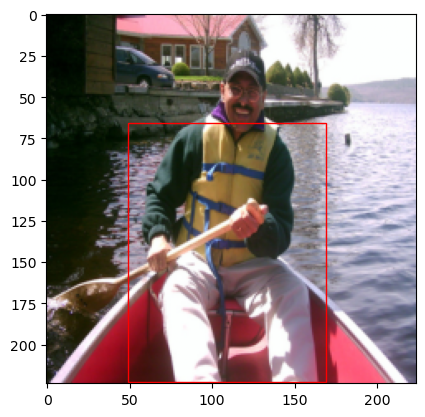

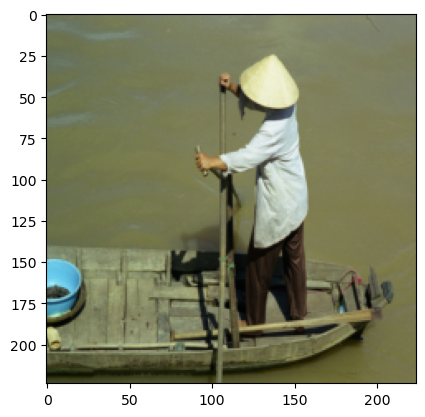

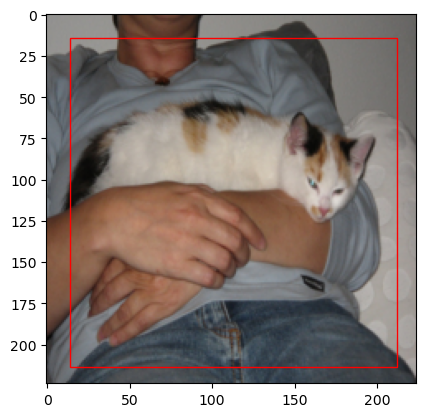

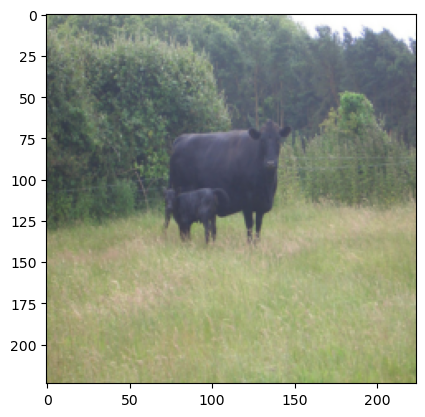

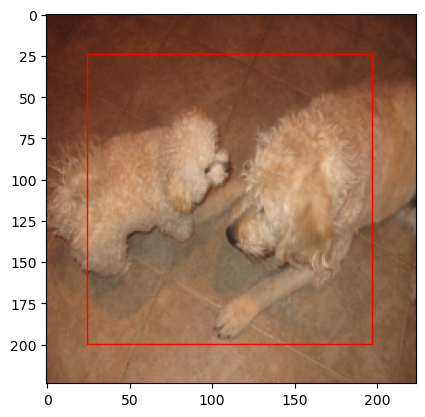

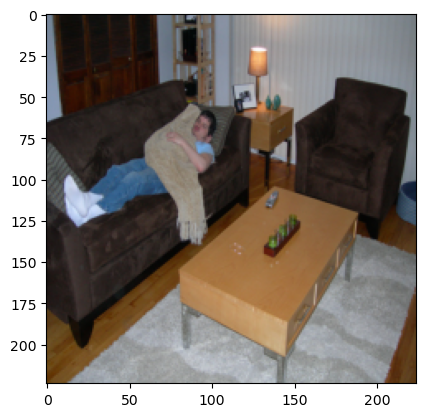

In [18]:
# Plot predictions on validation data
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(DEVICE)
        for idx in range(8):
            out = model(x)
            bboxes = cellboxes_to_boxes(out)
            bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
            plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)
        break

In [19]:
num_epochs = len(mean_avg_prec_history_train)

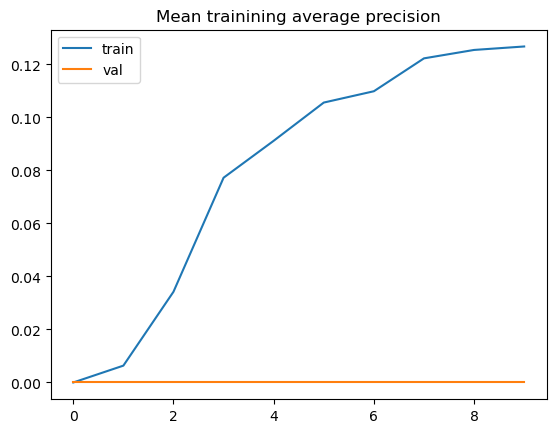

In [20]:
plt.plot(range(num_epochs), mean_avg_prec_history_train, label = 'train')
plt.plot(range(num_epochs), mean_avg_prec_history_val, label = 'val')
plt.title("Mean trainining average precision")
plt.legend()
plt.show()

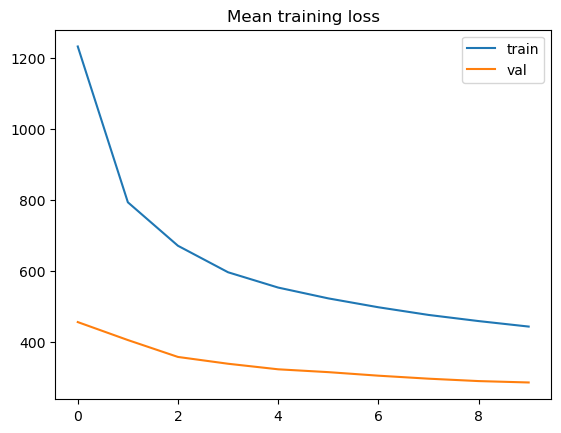

In [21]:
plt.plot(range(num_epochs), mean_loss_history_train, label = 'train')
plt.plot(range(num_epochs), mean_loss_history_val, label = 'val')
plt.title("Mean training loss")
plt.legend()
plt.show()

In [22]:
# saving a model
torch.save(model.state_dict(), SAVE_MODEL_PATH)